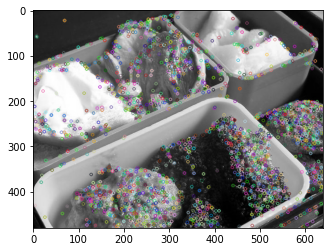

In [ ]:
import numpy as np
import cv2 as cv
from matplotlib import pyplot as plt
from skimage import *
import pandas as pd
import glob
import joblib
import base64

# пример
img = cv.imread('/content/drive/MyDrive/coco128/000000000009.jpg')
gray= cv.cvtColor(img,cv.COLOR_BGR2GRAY)
sift = cv.SIFT_create()
kp, des = sift.detectAndCompute(gray,None)
img=cv.drawKeypoints(gray,kp,img)
plt.imshow(img)
plt.show()

In [ ]:
# создаем базу дескрипторов (с ключевыми точками) для обучения
deses=[]
arr=[]
k=0
for i in glob.glob('/content/drive/MyDrive/coco128/*.jpg'):
  print(k)
  img = cv.imread(i)
  gray= cv.cvtColor(img,cv.COLOR_BGR2GRAY)
  sift = cv.SIFT_create()
  kp, des = sift.detectAndCompute(gray,None)
  for j in range(des.shape[0]):
    arr.append(des[j])
  k+=1

In [ ]:
# сохраняем как один большой вектор
deses = np.array(arr)
deses.shape

(186062, 128)

In [ ]:
# кластеризация
from sklearn.cluster import KMeans
model = KMeans(n_clusters=2048)
model.fit(deses)

KMeans(n_clusters=2048)

In [ ]:
# сохранение модели

joblib.dump(model, '/content/drive/MyDrive/machineLearningLabs/model_10Lab.sav')

['/content/drive/MyDrive/machineLearningLabs/model_10Lab.sav']

In [ ]:
# загрузка модели
loaded_model = joblib.load('/content/drive/MyDrive/machineLearningLabs/model_10Lab.sav')
loaded_model.predict(des)

array([1696,   99, 1179, ...,   11,  224, 1572], dtype=int32)

In [ ]:
# проходим по каждой карте и находим id, путь и вектор с предсказанием принадлежности к кластеру (по обученной модели)
ids = []
imgsPath = []
embeddings = []
k=0
for i in glob.glob('/content/drive/MyDrive/val2017/*'):
  print(k)
  k+=1
  ids.append(i.split('/')[-1][0:12])
  imgsPath.append(i)

  img = cv.imread(i)
  gray= cv.cvtColor(img,cv.COLOR_BGR2GRAY)
  sift = cv.SIFT_create()
  kp, des = sift.detectAndCompute(gray,None)
  embeddings.append(base64.b64encode(loaded_model.predict(des)))

In [ ]:
# сохраняем две таблицы - с путем и с вектором с предсказаниями класстеров дескриптора

imagesBase = {'id': ids, 'img_path': imgsPath}
imagesBaseDf = pd.DataFrame(data=imagesBase)
imagesBaseDf.to_csv('imagesBaseDf.csv',index=False)

vectorsBase = {'id': ids, 'embedding': embeddings}
vectorsBaseDf = pd.DataFrame(data=vectorsBase)
vectorsBaseDf.to_csv('vectorsBaseDf.csv',index=False)  

In [ ]:
# декодирование векторов (не с csv а сразу с кода!!!)
vectorsBaseDf['embedding'] = vectorsBaseDf['embedding'].apply(lambda x: np.frombuffer(base64.decodebytes(x), dtype=np.float32))
vectorsBaseDf

In [ ]:
# декодирование векторов с csv (он написал float64, но вообще числа в векторе были int32 - стоит уточнить)
# такая странная форма связана с тем что сохраняется строка а не байт
data00 = pd.read_csv("/content/vectorsBaseDf.csv", delimiter=',')
data00['embedding'] = data00['embedding'].apply(lambda x: np.frombuffer(base64.b64decode(bytes(x[2:-1],encoding='ascii')), dtype=np.int32))